In [8]:
### This script evaluates the MLM performance of LegalBERT and after it is transformed into Longformer.

In [9]:
### get ContractNLI dataset

from datasets import load_dataset, DatasetDict, Dataset
import json
from transformers import PerceiverTokenizer, PerceiverModel, PerceiverConfig, PerceiverPreTrainedModel, PerceiverForSequenceClassification, TrainingArguments, Trainer, \
    DataCollatorWithPadding
import re
import os
from tqdm import tqdm
import torch

ROOT_PATH = ".."

with open(os.path.join(ROOT_PATH, "ignored_dir/data/contract-nli/train.json")) as train_json_f:
    train_json = json.load(train_json_f)

id2label = {0: "Entailment", 1: "Contradiction", 2: "NotMnetioned"}
label2id = {"Entailment": 0, "Contradiction": 1, "NotMentioned": 2}

def load_dataset_custom(dataset_name):
    if dataset_name == "contract-nli":
        def contract_nli_iterator(data):
            documents, labels = data['documents'], data['labels']
            for document in documents:
                id = document['id']
                file_name = document['file_name']
                text = document['text']
                spans = document['spans']
                annotation_sets = document['annotation_sets']
                document_type = document['document_type']
                url = document['url']
                for annotation_id, annotation_content in annotation_sets[0]['annotations'].items():
                    hypothesis = labels[annotation_id]['hypothesis']
                    choice = annotation_content['choice']
                    yield {
                        "id": id,
                        "file_name": file_name,
                        "text": text,
                        "spans": spans,
                        "document_type": document_type,
                        "url": url,
                        "hypothesis": hypothesis,
                        "labels": label2id[choice],
                    }            
        base_filepath = os.path.join(ROOT_PATH, "ignored_dir/data/contract-nli")
        train_filepath = os.path.join(base_filepath, "train.json")
        validation_filepath = os.path.join(base_filepath, "dev.json")
        test_filepath = os.path.join(base_filepath, "test.json")
        with open(train_filepath) as f:
            train_data = json.load(f)
        with open(validation_filepath) as f:
            validation_data = json.load(f)
        with open(test_filepath) as f:
            test_data = json.load(f)
        data = {
            "train": Dataset.from_generator(lambda: contract_nli_iterator(train_data)),
            "validation": Dataset.from_generator(lambda: contract_nli_iterator(validation_data)),
            "test": Dataset.from_generator(lambda: contract_nli_iterator(test_data)),
        }
        return DatasetDict(data)
    return None

contract_nli_dataset = load_dataset_custom("contract-nli")

In [10]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import Dataset, DatasetDict
from transformers import DataCollatorForLanguageModeling

In [11]:
### transform ContractNLI into MLM format
### by making chunks of input_ids of length 512
### first stitch all text together, then tokenize them, then chunk them with overlap

### need tokanizer for this 
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

def convert_mode(ds_mode):
    big_text = ""
    sep_token = tokenizer.sep_token
    for h in ds_mode:
        premise = h['text']
        hypothesis = h['hypothesis']
        big_text += ( premise + sep_token + hypothesis + sep_token )
    tokenized_text = tokenizer(big_text).input_ids
    csize, osize = 512, 100
    idx = 0
    chunks = []
    while idx < len(tokenized_text):
        if idx + csize >= len(tokenized_text):
            chunk = tokenized_text[idx:]
            chunks.append(chunk)
            chunks.append(chunk)
            break
        else:
            chunk = tokenized_text[idx: idx + csize]
            chunks.append(chunk)
            idx += ( csize - osize)        
    return Dataset.from_dict({"input_ids": chunks})

contractnli_mlm_dataset = DatasetDict({mode: convert_mode(contract_nli_dataset[mode]) for mode in ['train', 'validation', 'test']})

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (15926736 > 512). Running this sequence through the model will result in indexing errors


In [12]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

base_dir = "../ignored_dir/training_outputs/legalbert_mlm"
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
run_idx = len(os.listdir(base_dir)) + 1
run_dir = os.path.join(base_dir, f"run_{run_idx}")

training_args = TrainingArguments(
    output_dir=run_dir,
    eval_strategy="epoch",
    learning_rate=1e-5,
    num_train_epochs=10,
    lr_scheduler_type="constant",
    # weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
)

In [13]:
model = AutoModelForMaskedLM.from_pretrained("nlpaueb/legal-bert-base-uncased")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=contractnli_mlm_dataset["train"],
    eval_dataset=contractnli_mlm_dataset["test"],
    data_collator=data_collator,
)

trainer.evaluate()

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.6286848187446594,
 'eval_runtime': 105.6755,
 'eval_samples_per_second': 108.246,
 'eval_steps_per_second': 1.694}

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.551300,0.545593
2,0.514000,0.531022
3,0.480800,0.518513
4,0.458700,0.511699
5,0.429900,0.511403
6,0.415300,0.509084
7,0.390500,0.514199
8,0.373300,0.510060
9,0.359300,0.511167
10,0.345600,0.516365


/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/yan_xu_uk_qbe_com/scc

TrainOutput(global_step=6050, training_loss=0.4415559702471268, metrics={'train_runtime': 6744.0702, 'train_samples_per_second': 57.321, 'train_steps_per_second': 0.897, 'total_flos': 1.01749716532224e+17, 'train_loss': 0.4415559702471268, 'epoch': 10.0})

In [20]:
import json
import os

base_dir = "../ignored_dir/training_outputs/legalbert_mlm"
run_dir = os.path.join(base_dir, "run_1")
latest_ckpt = max(os.listdir(run_dir), key=lambda x: int(x.split('-')[-1]))
latest_ckpt_path = os.path.join(run_dir, latest_ckpt)
json_path = os.path.join(latest_ckpt_path, "trainer_state.json")
with open(json_path) as f:
    json_f = json.load(f)
log_history = json_f['log_history']

train_loss_record, eval_loss_record, lr_record = dict(), dict(), dict()
for h in log_history:
    epoch = h['epoch']
    if "loss" in h:
        train_loss = h['loss']
        lr = h['learning_rate']
        train_loss_record[epoch] = train_loss
        lr_record[epoch] = lr
    else:
        eval_loss = h['eval_loss']
        eval_loss_record[epoch] = eval_loss

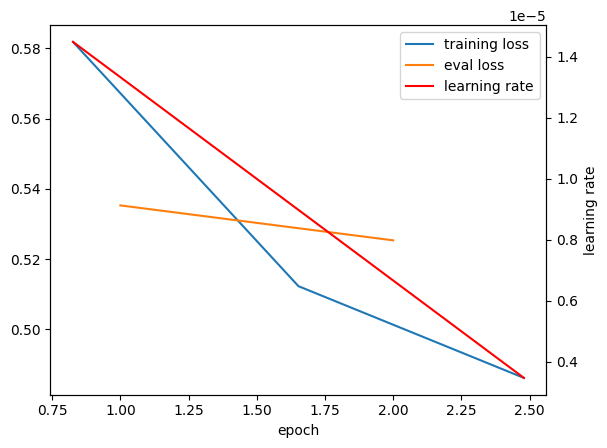

In [21]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

train_loss_keys = sorted(train_loss_record.keys())
train_loss_values = [train_loss_record[k] for k in train_loss_keys]
ax1.plot(train_loss_keys, train_loss_values, label="training loss")
eval_loss_keys = sorted(eval_loss_record.keys())
eval_loss_values = [eval_loss_record[k] for k in eval_loss_keys]
ax1.plot(eval_loss_keys, eval_loss_values, label="eval loss")
ax1.set_xlabel('epoch')
# ax1.legend()
h1, l1 = ax1.get_legend_handles_labels()
hc1 = [e.get_color() for e in h1]

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('learning rate')
lr_keys = sorted(lr_record.keys())
lr_values = [lr_record[k] for k in lr_keys]
ax2.plot(lr_keys, lr_values, label="learning rate", color='red')
# ax2.legend()
h2, l2 = ax2.get_legend_handles_labels()
hc2 = [e.get_color() for e in h2]

tmp, _ = ax2.get_legend_handles_labels()
tmp = tmp[0]

colors = hc1 + hc2
labels = l1 + l2
handles = [mlines.Line2D([], []) for _ in range(len(colors))]
for i, h in enumerate(handles):
    h.update_from(tmp)
    h.set_label(labels[i])
    h.set_color(colors[i])

plt.legend(handles, labels) # , bbox_to_anchor=(2.2, 0.5)) # , colors=['blue', 'orange', 'green', 'red'])

plt.show()
# plt.savefig("perceiver_snli_more_param.png", bbox_inches = 'tight')

In [22]:
import json
import os

base_dir = "../ignored_dir/training_outputs/legalbert_mlm"
run_dir = os.path.join(base_dir, "run_2")
latest_ckpt = max(os.listdir(run_dir), key=lambda x: int(x.split('-')[-1]))
latest_ckpt_path = os.path.join(run_dir, latest_ckpt)
json_path = os.path.join(latest_ckpt_path, "trainer_state.json")
with open(json_path) as f:
    json_f = json.load(f)
log_history = json_f['log_history']

train_loss_record, eval_loss_record, lr_record = dict(), dict(), dict()
for h in log_history:
    epoch = h['epoch']
    if "loss" in h:
        train_loss = h['loss']
        lr = h['learning_rate']
        train_loss_record[epoch] = train_loss
        lr_record[epoch] = lr
    else:
        eval_loss = h['eval_loss']
        eval_loss_record[epoch] = eval_loss

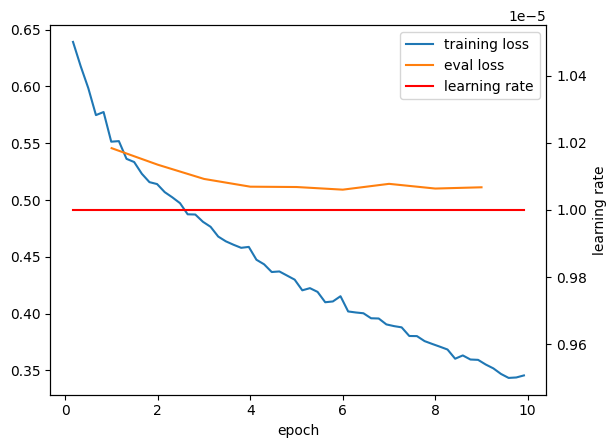

In [25]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

train_loss_keys = sorted(train_loss_record.keys())
train_loss_values = [train_loss_record[k] for k in train_loss_keys]
ax1.plot(train_loss_keys, train_loss_values, label="training loss")
eval_loss_keys = sorted(eval_loss_record.keys())
eval_loss_values = [eval_loss_record[k] for k in eval_loss_keys]
ax1.plot(eval_loss_keys, eval_loss_values, label="eval loss")
ax1.set_xlabel('epoch')
# ax1.legend()
h1, l1 = ax1.get_legend_handles_labels()
hc1 = [e.get_color() for e in h1]

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('learning rate')
lr_keys = sorted(lr_record.keys())
lr_values = [lr_record[k] for k in lr_keys]
ax2.plot(lr_keys, lr_values, label="learning rate", color='red')
# ax2.legend()
h2, l2 = ax2.get_legend_handles_labels()
hc2 = [e.get_color() for e in h2]

tmp, _ = ax2.get_legend_handles_labels()
tmp = tmp[0]

colors = hc1 + hc2
labels = l1 + l2
handles = [mlines.Line2D([], []) for _ in range(len(colors))]
for i, h in enumerate(handles):
    h.update_from(tmp)
    h.set_label(labels[i])
    h.set_color(colors[i])

plt.legend(handles, labels) # , bbox_to_anchor=(2.2, 0.5)) # , colors=['blue', 'orange', 'green', 'red'])

# plt.show()
plt.savefig("legalbert_contractnli_mlm.png", bbox_inches = 'tight')